In [1]:
!echo "deb http://downloads.skewed.de/apt bionic main" >> /etc/apt/sources.list
!apt-key adv --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-cairo python3-matplotlib

Executing: /tmp/apt-key-gpghome.IjjFAvCY7Q/gpg.1.sh --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
gpg: key 612DEFB798507F25: public key "Tiago de Paula Peixoto <tiago@skewed.de>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [39.3 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Get:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:8 https://developer.download.nvidia.com/compute/machine-le

In [3]:
#from graph_tool.all import *
import graph_tool.all as gr_t
#g = gr_t.collection.data["celegansneural"]
#state = gr_t.minimize_nested_blockmodel_dl(g)

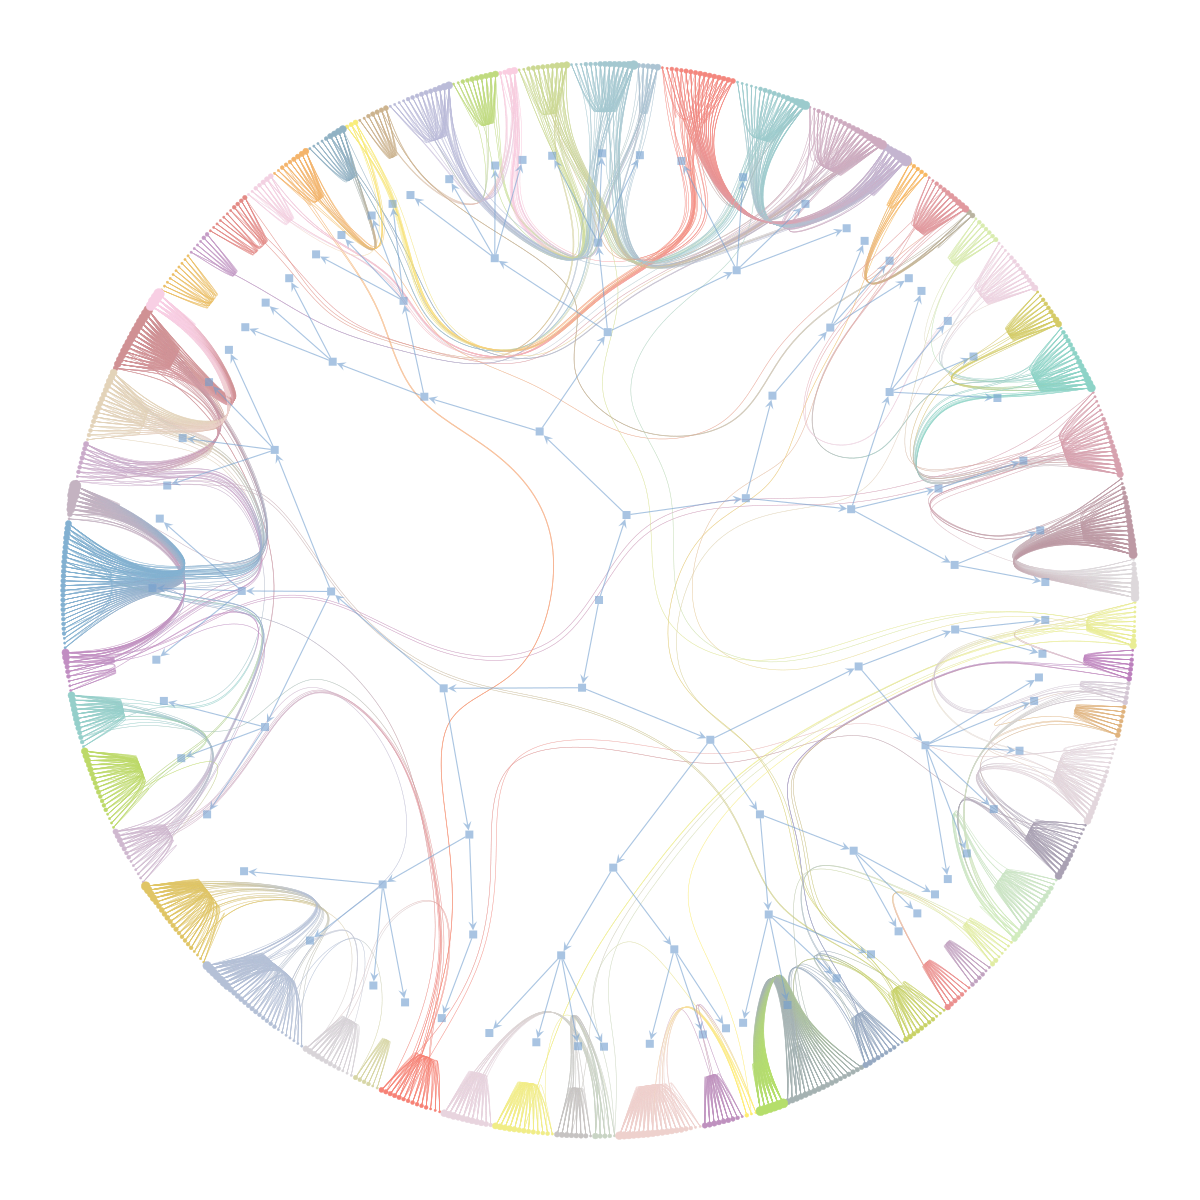

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f4883303128, at 0x7f4884a527f0>,
 <Graph object, directed, with 804 vertices and 803 edges, at 0x7f4884adae10>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f4884adae10, at 0x7f4884afd438>)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import networkx as nx
import xlrd
from queue import PriorityQueue
from math import inf
import copy
import random
import timeit
import math

In [57]:
file_loc="/content/votes_of_9th_parlament(01-02-2020_31-04-2020).xlsx"
df = pd.read_excel(file_loc)
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,22330,22331,22332,22333,22334,22335,22336,22337,22338,22339,22340,22341,22342,22343,22344,22345,22346,22347,22348,22349,22350,22351,22352,22353,22354,22355,22356,22357,22358,22359,22360,22361,22362,22363,22364,22365,22366,22367,22368,22369,...,22525,22526,22527,22528,22529,22530,22531,22532,22533,22534,22535,22536,22537,22538,22539,22540,22541,22542,22543,22544,22545,22546,22547,22548,22549,22550,22551,22552,22553,22554,22555,22556,22557,22558,22559,22560,22561,22562,22563,22564
0,-1,-1,-1,1,-1,1,-1,-1,-1,1,1,1,-1,1,-1,1,-1,-1,-1,-1,1,-1,-1,1,1,-1,-1,1,1,1,1,1,1,1,1,1,1,-1,1,-1,...,-1,1,1,1,-1,-1,1,1,1,1,1,1,1,1,1,1,-1,-1,-1,-1,-1,1,-1,1,-1,1,-1,1,1,-1,1,1,1,1,1,-1,1,1,1,1
1,-1,-1,-1,1,0,1,-1,-1,1,1,1,1,-1,1,1,1,-1,-1,-1,-1,1,-1,-1,1,1,1,1,1,1,1,1,1,1,-1,1,1,1,-1,1,1,...,-1,1,1,1,1,-1,1,1,1,1,1,1,1,1,1,1,-1,-1,-1,-1,-1,1,-1,1,-1,1,-1,1,1,-1,1,1,1,1,1,-1,1,1,1,1
2,0,0,0,0,0,1,-1,-1,1,1,1,1,-1,1,1,1,-1,-1,-1,-1,1,-1,-1,1,1,1,1,1,1,1,1,1,1,-1,1,1,1,-1,0,1,...,-1,1,1,1,1,-1,1,1,1,1,1,1,1,1,1,1,-1,-1,-1,-1,-1,1,-1,1,-1,1,-1,1,1,-1,1,1,1,1,1,-1,1,1,1,1
3,-1,1,0,1,1,-1,-1,-1,1,1,0,-1,-1,-1,1,1,-1,-1,-1,-1,1,0,0,1,1,1,1,1,1,1,1,1,1,-1,1,1,1,-1,1,1,...,-1,1,1,1,1,-1,1,1,1,1,1,1,1,1,1,1,-1,-1,-1,-1,-1,1,-1,1,-1,1,-1,1,1,-1,1,1,1,1,1,-1,1,1,1,1
4,-1,-1,-1,1,-1,1,-1,-1,-1,1,1,1,-1,1,-1,0,1,-1,-1,-1,1,-1,-1,1,1,1,-1,1,1,1,1,1,1,-1,1,1,1,-1,-1,-1,...,-1,1,1,1,-1,-1,1,1,1,1,1,1,1,1,1,1,-1,-1,-1,-1,-1,1,-1,1,-1,1,-1,1,1,-1,1,1,1,1,1,-1,1,1,1,1


In [58]:
total_num_of_votes = _matrix.shape[1]
t = (df[df.columns] == 0).sum(axis=1)
df['Count_v'] = t
t = df['Count_v'] > 0.75*total_num_of_votes
m = t[t==True].index
df.drop(index=m,inplace=True)
df.drop(columns=['Count_v'],inplace=True)

In [59]:
df.head()

,22330,22331,22332,22333,22334,22335,22336,22337,22338,22339,22340,22341,22342,22343,22344,22345,22346,22347,22348,22349,22350,22351,22352,22353,22354,22355,22356,22357,22358,22359,22360,22361,22362,22363,22364,22365,22366,22367,22368,22369,...,22525,22526,22527,22528,22529,22530,22531,22532,22533,22534,22535,22536,22537,22538,22539,22540,22541,22542,22543,22544,22545,22546,22547,22548,22549,22550,22551,22552,22553,22554,22555,22556,22557,22558,22559,22560,22561,22562,22563,22564
0,-1,-1,-1,1,-1,1,-1,-1,-1,1,1,1,-1,1,-1,1,-1,-1,-1,-1,1,-1,-1,1,1,-1,-1,1,1,1,1,1,1,1,1,1,1,-1,1,-1,...,-1,1,1,1,-1,-1,1,1,1,1,1,1,1,1,1,1,-1,-1,-1,-1,-1,1,-1,1,-1,1,-1,1,1,-1,1,1,1,1,1,-1,1,1,1,1
1,-1,-1,-1,1,0,1,-1,-1,1,1,1,1,-1,1,1,1,-1,-1,-1,-1,1,-1,-1,1,1,1,1,1,1,1,1,1,1,-1,1,1,1,-1,1,1,...,-1,1,1,1,1,-1,1,1,1,1,1,1,1,1,1,1,-1,-1,-1,-1,-1,1,-1,1,-1,1,-1,1,1,-1,1,1,1,1,1,-1,1,1,1,1
2,0,0,0,0,0,1,-1,-1,1,1,1,1,-1,1,1,1,-1,-1,-1,-1,1,-1,-1,1,1,1,1,1,1,1,1,1,1,-1,1,1,1,-1,0,1,...,-1,1,1,1,1,-1,1,1,1,1,1,1,1,1,1,1,-1,-1,-1,-1,-1,1,-1,1,-1,1,-1,1,1,-1,1,1,1,1,1,-1,1,1,1,1
3,-1,1,0,1,1,-1,-1,-1,1,1,0,-1,-1,-1,1,1,-1,-1,-1,-1,1,0,0,1,1,1,1,1,1,1,1,1,1,-1,1,1,1,-1,1,1,...,-1,1,1,1,1,-1,1,1,1,1,1,1,1,1,1,1,-1,-1,-1,-1,-1,1,-1,1,-1,1,-1,1,1,-1,1,1,1,1,1,-1,1,1,1,1
4,-1,-1,-1,1,-1,1,-1,-1,-1,1,1,1,-1,1,-1,0,1,-1,-1,-1,1,-1,-1,1,1,1,-1,1,1,1,1,1,1,-1,1,1,1,-1,-1,-1,...,-1,1,1,1,-1,-1,1,1,1,1,1,1,1,1,1,1,-1,-1,-1,-1,-1,1,-1,1,-1,1,-1,1,1,-1,1,1,1,1,1,-1,1,1,1,1


In [ ]:
import seaborn as sns
plt.figure(figsize=(20, 10))
sns.countplot(df['Count_v'])
plt.tight_layout()

In [60]:
# Находим матрицу несхожести депутатов через евклидово расстояние между векторами (строками исхондой таблицы)
# Для каждого i - депутата находим 4 депутата ближайших по взглядам (наименьшие значения в матрице несхожести в строке i - депутата)
# Строим матрицу смежности соединяя депутатов с 4-мя ближайшими. 
MAX_LENGTH_OF_EDGE = 6
_matrix = df.values
test_dist_matrix = np.zeros((_matrix.shape[0],_matrix.shape[0]))
for i in range(test_dist_matrix.shape[0]):
  for j in range(test_dist_matrix.shape[0]):
    
    test_dist_matrix[i,j]=np.linalg.norm(_matrix[i] - _matrix[j])
    if (i==j):
      test_dist_matrix[i,j] = 2*_matrix.shape[0]

test_adj_matrix = np.zeros(test_dist_matrix.shape)
for i in range(_matrix.shape[0]):
  minus_vote = pd.Series(-test_dist_matrix[i])
  n_large = minus_vote.nlargest(4, keep='all')
  test_adj_matrix[i,n_large.index]=1
for i in range(test_adj_matrix.shape[0]):
  for j in range(i,test_adj_matrix.shape[1]):
    if (test_adj_matrix[i][j] != 0) or (test_adj_matrix[j][i] != 0):
      val = np.random.randint(1,MAX_LENGTH_OF_EDGE)
      test_adj_matrix[i][j] = val
      test_adj_matrix[j][i] = val
    if (i == j):
      test_adj_matrix[i][i] = 0


In [61]:
test_adj_matrix.shape

(701, 701)

In [105]:
# функция для создания графа по матрице смежности (с помощью библиотеки NetworkX)
def create_graph(adjacency_matrix):
    #   https://carlonicolini.github.io/sections/science/2018/09/12/weighted-graph-from-adjacency-matrix-in-graph-tool.html
    #   https://stackoverflow.com/questions/23288661/create-a-weighted-graph-from-an-adjacency-matrix-in-graph-tool-python-interface
    g = gr_t.Graph(directed=False)
    g.add_edge_list(np.transpose(adjacency_matrix.nonzero()))
    idx = adjacency_matrix.nonzero()
    weights = adjacency_matrix[idx]
    ew = g.new_edge_property("double")
    ew.a = weights 
    g.ep['edge_weight'] = ew
    return g

In [106]:
graph_test = create_graph(test_adj_matrix)

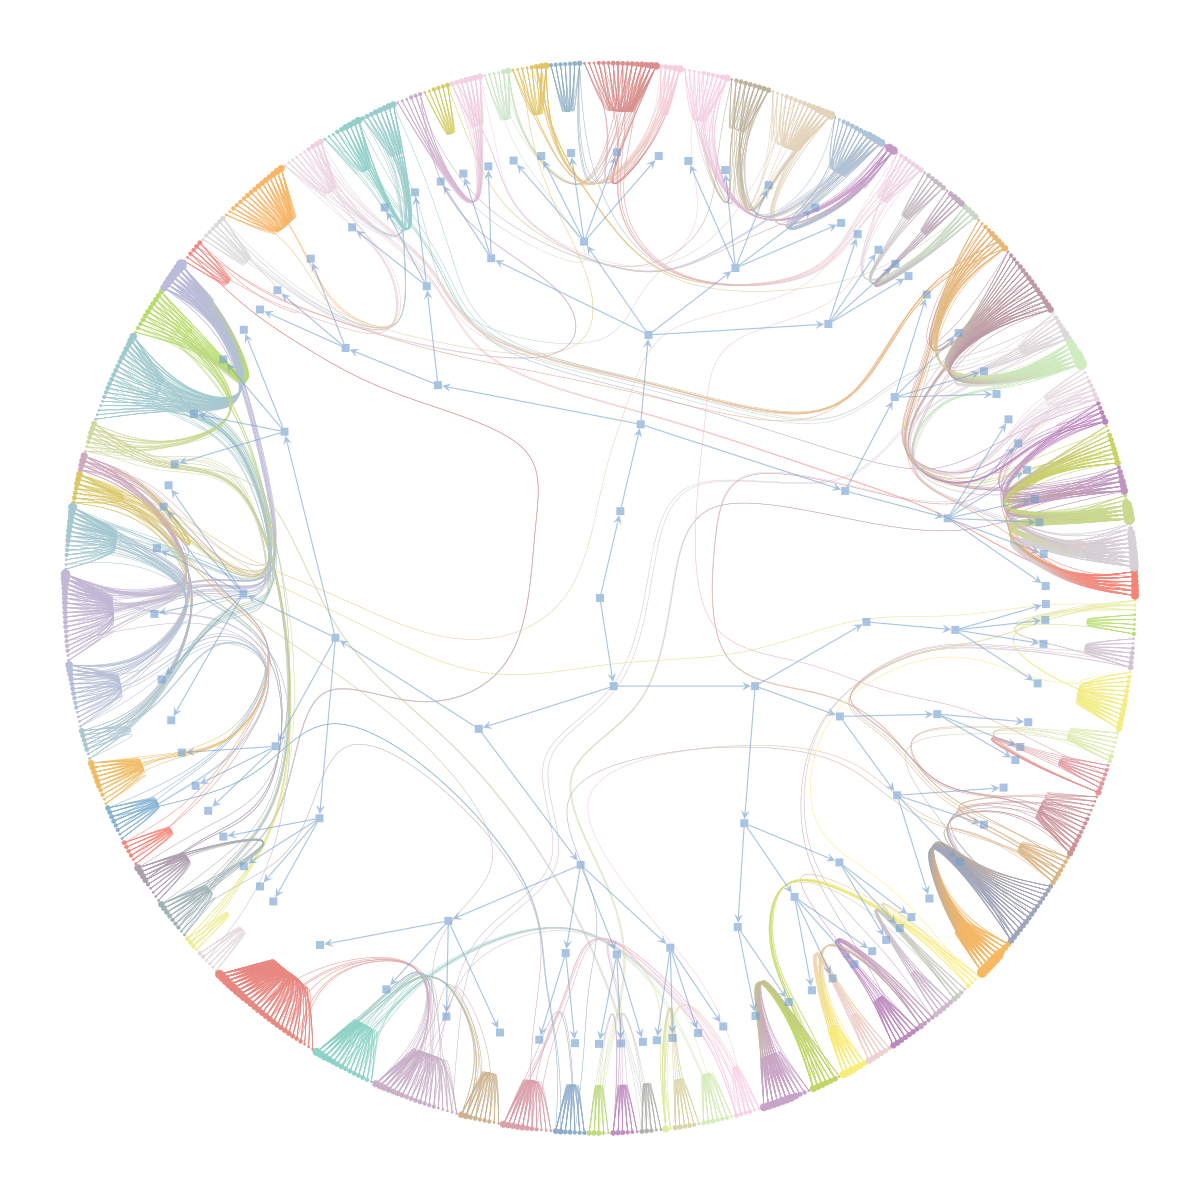

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f84a0c68320, at 0x7f84a140a240>,
 <Graph object, directed, with 821 vertices and 820 edges, at 0x7f84ddd0e390>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f84ddd0e390, at 0x7f84ac916668>)

In [143]:
state = gr_t.minimize_nested_blockmodel_dl(graph_test)
state.draw()

In [142]:
comp, hist = gr_t.label_components(graph_test, attractors=True)
u =[]
for i in range(len(hist)):
  u.append(gr_t.GraphView(graph_test, vfilt=comp.a == i).get_vertices())
conn_idx=[]
for i in range(len(u)):
  for j in range(i,len(u)):
    min_dist=2*_matrix.shape[0]
    for m in u[i]:
      for c in u[j]:
        if (test_dist_matrix[m,c] < min_dist):
          min_dist= test_dist_matrix[m,c]
    for m in u[i]:
      for c in u[j]:
        if (test_dist_matrix[m,c] == min_dist):
          conn_idx.append((m,c))

if (len(hist) != 1):
    for t,j in conn_idx:
      graph_test.add_edge(graph_test.vertex(t), graph_test.vertex(j))
      graph_test.edge_properties['edge_weight'][graph_test.edge(t, j)] = 1.0